# Robotics Foundations (H) - Lab 5

## ILOs

At the end of the lab, you should be able to:
* Add a depth sensor in Gazebo and display images and depth information in RViz
* Detect red blocks as captured by the RGB-D sensor
* Pick and place a block using visual feedback

## Introduction

Vision is the most essential of senses. The latter holds for robotic systems as it allows a robot to survey the environment without needing direct contact with the objects in the scene. So, let's integrate a camera into Baxter's simulation in order to manipulate captured images to solve the Pick-'n-Place task (i.e. Lab 4) without retrieving the pose of the block using TF.

For this, we will use a Microsoft Kinect camera, i.e. a depth or RGB-D cameras. Depth cameras usually project a structured light -- as covered in RF lectures. The device projects a known pattern into the scene, a  camera observes how this pattern is deformed as it lands on the various objects and surfaces of the scene, and finally, a reconstruction algorithm estimates the 3D structure of the scene from this data.

It’s hard to overstate the impact that the Kinect has had on modern robotics! It was designed for the gaming market, which is orders of magnitude larger than the robotics sensor market. The price of the Kinect is around £100, which is incredibly cheap for a sensor capable of outputting useful 3D data. Many robots were quickly retrofitted to hold Kinects, and the sensor continues to be used across research and industry.  The Kinect has the following three sensors that you can use for vision and robotics tasks:

* A colour camera to capture colour images
* A depth sensor, which is an infrared projector and a monochrome image sensor working together -- this allows the sensor to extract depth information from the environment.
* A multiarray microphone that is used to isolate the voices of the players from the noise in the room

The following section will show you how to integrate the Kinect within Baxter's simulation.

## Interfacing the Kinect in ROS/Gazebo

In this lab, we will use the colour camera and the depth sensor. To use this sensor, you need to install the following packages (run the command below in a terminal):

``` bash
sudo apt install ros-melodic-openni-camera ros-melodic-openni-launch
```

The above packages comprise the camera driver for the Kinect and related ROS packages. After installing these packages, you should be able to launch and capture colour and depth images using the Kinect; however, you have been using Gazebo to simulate Baxter, and this simulator does not include a Kinect camera. So to integrate this sensor into the simulator and, ultimately, Baxter, you need to do the following:

1. Go to this lab's source directory, i.e. `~/Desktop/RFLabs/lab5/src`, using the File Manager, and locate the `meshes` folder.
2. In a new File Manager window, navigate to `~/ros_ws/src/baxter/baxter/baxter_common/baxter_description/`.
3. You then need to add the Kinect Gazebo model into Baxter's XACRO files. So copy `kinect.dae` and `kinect.png` file into `baxter_description/meshes` folder.
4. In Baxter's `baxter_description/urdf` folder, create a new XACRO file named `kinect_sim.urdf.xacro` and add the following markup code into the file. This XACRO file sets up how the camera should be controlled (i.e. `camera_plugin`), camera intrinsic parameters and how information should be passed to ROS (i.e. ROS topics that need to be advertised). Most of these values are standard, and you can use them as they are defined. We have covered camera parameters during the Vision lectures, do refer to those lectures to find out more about them!

``` xml
<?xml version="1.0"?>
<robot name="kinect_sim" xmlns:xacro="http://ros.org/wiki/xacro">
  <xacro:property name="M_PI" value="3.1415926535897931" /> 
  <xacro:macro name="kinect_camera">
    <gazebo reference="camera_link">  
      <sensor type="depth" name="camera">
        <always_on>true</always_on>
        <update_rate>20.0</update_rate>
        <camera>
          <horizontal_fov>${60.0*M_PI/180.0}</horizontal_fov>
          <image>
            <format>B8G8R8</format>
            <width>640</width>
            <height>480</height>
          </image>
          <clip>
            <near>0.05</near>
            <far>8.0</far>
          </clip>
        </camera>
        <plugin name="kinect_camera_controller" filename="libgazebo_ros_openni_kinect.so">
          <cameraName>camera</cameraName>
          <alwaysOn>true</alwaysOn>
          <updateRate>5</updateRate>
          <imageTopicName>rgb/image_raw</imageTopicName>
          <depthImageTopicName>depth/image_raw</depthImageTopicName>
          <pointCloudTopicName>depth/points</pointCloudTopicName>
          <cameraInfoTopicName>rgb/camera_info</cameraInfoTopicName>
          <depthImageCameraInfoTopicName>depth/camera_info</depthImageCameraInfoTopicName>
          <frameName>camera_depth_optical_frame</frameName>
          <baseline>0.1</baseline>
          <distortion_k1>0.0</distortion_k1>
          <distortion_k2>0.0</distortion_k2>
          <distortion_k3>0.0</distortion_k3>
          <distortion_t1>0.0</distortion_t1>
          <distortion_t2>0.0</distortion_t2>
          <pointCloudCutoff>0.4</pointCloudCutoff>
        </plugin>
      </sensor>
    </gazebo>
  </xacro:macro>
</robot>
```

5. You now need to tell XACRO where to position the camera with respect to the robot. For this, you will create a new file named `depth_sensor.urdf.xacro` inside `baxter_description/urdf` where you will create a XACRO macro taking as argument a `parent` reference frame and the `pose` of the Kinect from the `parent` frame as `x y z roll pitch yaw`. The latter will allow you to change the parent frame to position the Kinect wherever you like. Go over the XACRO code to find out what this macro is about and if you have questions, do ask us! You will notice that the camera has several joints and links; these define where the actual cameras are located within the sensor and their pose with respect to the parent frame.

``` xml
<?xml version="1.0"?>
<robot name="depth_sensor" xmlns:xacro="http://ros.org/wiki/xacro">
  <xacro:include filename="$(find baxter_description)/urdf/kinect_sim.urdf.xacro"/>

  <xacro:macro name="sensor_kinect" params="parent location orientation">
    <joint name="camera_rgb_joint" type="fixed">
      <origin xyz="${location}" rpy="${orientation}"/>
      <parent link="${parent}"/>
      <child link="camera_rgb_frame" />
    </joint>
    <link name="camera_rgb_frame"/>

    <joint name="camera_rgb_optical_joint" type="fixed">
      <origin xyz="0 0 0" rpy="${-M_PI/2} 0 ${-M_PI/2}" />
      <parent link="camera_rgb_frame" />
      <child link="camera_rgb_optical_frame" />
    </joint>
    <link name="camera_rgb_optical_frame"/>

    <joint name="camera_joint" type="fixed">
      <origin xyz="0 0 0" rpy="0 0 0"/> <!-- -0.031 -0.0125 -0.016 -->
      <parent link="camera_rgb_frame"/>
      <child link="camera_link"/>
    </joint>  
      <link name="camera_link">
      <visual>
       <origin xyz="0 0 0" rpy="0 0 0"/>
        <geometry>
         <mesh filename="package://baxter_description/meshes/kinect.dae"/>
        </geometry>
      </visual>
        <collision>
        <origin xyz="0.0 0.0 0.0" rpy="0 0 0"/>
          <geometry>
            <box size="0.07271 0.27794 0.073"/>
          </geometry>
        </collision>
      <inertial>
        <mass value="0.564" />
        <origin xyz="0 0 0" />
        <inertia ixx="0.003881243" ixy="0.0" ixz="0.0"
                 iyy="0.000498940" iyz="0.0"
                 izz="0.003879257" />
      </inertial>
    </link>

    <!-- The fixed joints & links below are usually published by static_transformers launched by the OpenNi launch files. However, for Gazebo simulation we need them, so we add them here and aren't published by static_transformers!) -->
    <joint name="camera_depth_joint" type="fixed">
      <origin xyz="0 ${2 * 0.0125} 0" rpy="0 0 0" />
      <parent link="camera_rgb_frame" />
      <child link="camera_depth_frame" />
    </joint>
    <link name="camera_depth_frame"/>

    <joint name="camera_depth_optical_joint" type="fixed">
      <origin xyz="0 0 0" rpy="${-M_PI/2} 0 ${-M_PI/2}" />
      <parent link="camera_depth_frame" />
      <child link="camera_depth_optical_frame" />
    </joint>
    <link name="camera_depth_optical_frame"/>

    <!-- Kinect sensor for simulation -->
    <kinect_camera/>
  </xacro:macro>
</robot>
```

6. Finally, just before the `</robot>` closing tag in `baxter.urdf.xacro`, add the following XACRO code to define the Kinect sensor within the robot description. In this XACRO definition, you set the `parent` and `pose` of the Kinect, which in this case, you are setting the Kinect with respect to the `base` and positioning the sensor above the table:

``` xml
  <!-- Kinect Sensor -->
  <xacro:if value="$(arg gazebo)">
    <xacro:include filename="$(find baxter_description)/urdf/depth_sensor.urdf.xacro" />
    <sensor_kinect parent="base" location="1.0 -0.0125 2.0" orientation="0 1.57 0.0"/>
  </xacro:if>

  <!-- Coffe Table -->
  <xacro:include filename="$(find baxter_sim_examples)/models/cafe_table/cafe_table.xacro" />
```

Note that you are also adding the Coffe Table model for RViz, similar to Lab 4 and this model is located in `baxter_sim_examples` to make this lab self-contained. If you happened to have a coffee table already defined in `baxter.urdf.xacro`, please do remove one as it will create conflicts while XACRO processes the file. If `baxter_sim_examples/models/cafe_table/` doesn't have `cafe_table.xacro`, we have included the XACRO file in this lab's `src` folder (e.g. `~/Desktop/RFLabs/lab5/src/`), so just copy it over. You are now ready to test the Kinect in Gazebo and RViz! So run the following in a terminal:

``` bash
roslaunch baxter_gazebo baxter_world.launch
```

After Gazebo finishes to load, go to the `Insert` tab (in Gazebo) and add an object within the field of view of the Kinect, so it captures something. To do this, go to the `Insert` tab and search for the `Cafe Table` object and place it in front of Baxter - the position doesn't matter right now, be sure it is in front of Baxter. Now, open a new terminal and run RViz:

``` bash
rosrun rviz rviz
```

This command will start Rviz without the MoveIt! Interface. Now, in RViz, change the `Fixed Frame` to `world`, and click on `Add` then select the `By topic` tab. Double-click on `camera->depth->points`, select  `PointCloud2` and click on `OK`. You will get the point cloud (i.e. the Kinect's depth video stream) as captured by the Kinect in Gazebo. You can also add the Robot Model plugin to get the captured point cloud into context. You should get something similar to Figure 1. Press Ctrl+C Gazebo and RViz because displaying point clouds is computationally expensive and may slow the virtual machine!

![pointcloud.png](imgs/pointcloud.png)
<div style="text-align:center"><b>Figure 1: Point cloud captured using the simulated Kinect in Gazebo</b><br></div>

As in Lab 4, you can spawn objects using a ROS node. For this, you will use part of the code that spawns objects into the simulator. So create a new ROS package for this (you will use this package for the rest of the notebook) by opening a new terminal and run the following inside `~/rf_ws/src`:

``` bash
catkin_create_pkg lab5_pkg rospy gazebo_msgs std_msgs gazebo_ros gazebo_msgs
```

Now, copy `add_gazebo_models.py` from `~/Desktop/RFLabs/lab5/src/code` to `lab5_pkg/src`, make it executable,  run `catkin_make` in `rf_ws` and source the terminal in order to register `lab5_pkg` in ROS's path. Do inspect the code to find out what's going on -- you will notice that the code is a snippet of lab4 Python script. Run Gazebo launch again and run the following in a different terminal (remember to source `rf_ws`!):

``` bash
rosrun lab5_pkg add_gazebo_models.py
```

Now run `rosrun rviz rviz` in a different terminal, set the `Fixed Frame` to `world` and subscribe to the `PointCloud2` topic as you did before. You should get a point cloud as shown in Figure 2. As you can see, the box and table appear within RViz; add the `RobotModel` plugin in RViz -- you will notice that the coffee table defined in Baxter's XACRO files now aligned to the captured point cloud!

![rviz_gazebo_aligned.png](imgs/rviz_gazebo_aligned.png)
<div style="text-align:center"><b>Figure 2: Point cloud captured using the simulated Kinect in Gazebo</b><br></div>

## Capturing and saving an image

So far you have set up the framework to use the Kinect with Baxter. Now let's get information out of the Kinect. The Kinect simulation provides several topics of which you can subscribe/advertise with ROS nodes. To find out which topics are available, press Shift+Enter in the following cell:

In [1]:
%%bash
rostopic list /camera

/camera/depth/camera_info
/camera/depth/image_raw
/camera/depth/points
/camera/parameter_descriptions
/camera/parameter_updates
/camera/rgb/camera_info
/camera/rgb/image_raw
/camera/rgb/image_raw/compressed
/camera/rgb/image_raw/compressed/parameter_descriptions
/camera/rgb/image_raw/compressed/parameter_updates
/camera/rgb/image_raw/compressedDepth
/camera/rgb/image_raw/compressedDepth/parameter_descriptions
/camera/rgb/image_raw/compressedDepth/parameter_updates
/camera/rgb/image_raw/theora
/camera/rgb/image_raw/theora/parameter_descriptions
/camera/rgb/image_raw/theora/parameter_updates


The topics that you are more likely to subscribe are the `/camera/rgb/image_raw` and `/camera/depth/points`. These will allow you to capture colour images or depth images (not that depth images are not the same as point clouds), respectively. `/camera/depth/image_raw` publishes 2D images of the same size as the `/camera/rgb/image_raw` images but pixels have depth values instead of intensities. The topics ending with `camera_info` contain camera calibration information. The other topics provide a transport to change parameters of the camera using the [`dynamic_configure`](http://wiki.ros.org/dynamic_reconfigure) package. In this course, you will not use the `dynamic_configure` package as the Kinect is simulated and you have a controlled environment, in a real setting, you will use this package to adjust the brightness, contrast, etc.

To capture images, you can create your own node and subscribe to the `/camera/rgb/image_raw` or reuse a ROS package that already provides this! See the [`image_view`](http://wiki.ros.org/image_view) package. For now, you will use RViz plugin to display images. So, go to RViz, click `Add` then select the `By topic` tab, double-click on `camera->rgb->image_raw`, select `Image` and click on OK.

The Image plugin will subcribe to the `/camera/rgb/image_raw` topic and display images as they are being published by the Kinect. Figure 3 shows a captured image using `image_view`.

![image_box.png](imgs/image_box.png)
<div style="text-align:center"><b>Figure 3: Captured image using the Kinect in Gazebo</b><br></div>

## Detecting the red block using OpenCV

You are now ready to process the captured image to extract information out of it. In the Vision lecture, you were introduced to the basics of computer vision and image processing. In this section, you will apply some of the concepts you learnt. For this, you want to locate where the red box is in the image and use this to extract the pose of the box so Baxter can pick it up and place it somewhere else using a "top grasp" approach. By using the computer vision library [OpenCV](https://opencv.org/), it is possible to devise a vision pipeline to accomplish this robot vision task:

1. Apply a pixel-wise colour transformation to find red boxes on the table.
3. Apply the Canny edge detector to extract edge information from the image.
2. Find dominant contours from the extracted edges and return a structure pointing to each contour.
3. For each contour check the size of the contour by computing its area ([Image moments](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT2/node3.html)), and discard contours that fall outside an acceptable range of areas for the type of box being grasped.
4. For each retained contour, compute a set of moments to retrieve: the contour centroid location, major axis length, minor axis length and major axis orientation
5. Obtain the 3D point of the blob's centroid location and use the image moments to compute the orientation of the block with respect to the `base` of Baxter.

The above list is reflected in the following Python script (Ctrl+Enter to evaluate the following cells).

**NOTE:** If you see text in the output below the next cell, please re-evaluate the cell to get images displayed!

In [2]:
import cv2  #Import OpenCV modules
import matplotlib
from matplotlib import pyplot as plt  # To display images within Jupyter

# Load the captured using image_view
img = cv2.imread('imgs/image_box.png')
# Print the image dimensions (X, Y, Channel)
print img.shape

# ROS uses a BGR ordering (Blue, Green, Red) but most OpenCV functions work
# with the RGB ordering. So you can swap colour channels as follow
b,g,r = cv2.split(img)       # get b,g,r
rgb_img = cv2.merge([r,g,b])     # switch it to rgb

# Display the RGB image
plt.imshow(rgb_img)
plt.title('Input image')
plt.show()

# Step 1. Segment red blocks in the image
# As blocks are red, you only need to use the red channel for this
red_channel = r.copy()
# clip image by intensities, only retain pixels that within the 127-255 range
# cv2.treshold will return a binary image where bright pixels denote retained red pixels
_,img_bin = cv2.threshold(red_channel,200,255,cv2.THRESH_BINARY) 

# Display tresholded image
plt.imshow(img_bin)
plt.title('Tresholding the red channel')
plt.show()

(466, 527, 3)


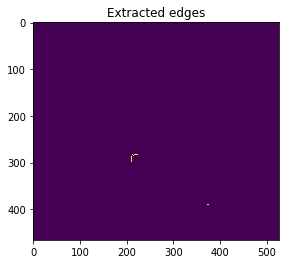

In [3]:
# Step 2. Apply Canny
# convert the image to grayscale, blur it, and find edges
# in the image using the Canny edge detector
edges = cv2.Canny(img_bin,5,50)

# Display extracted edges
plt.imshow(edges)
plt.title('Extracted edges')
plt.show()

Perimeter: 8.0
Perimeter: 4.82842707634
Perimeter: 112.142135382
Centroid: (218.4202117919922, 291.4367980957031)
Angle: 24.647233963


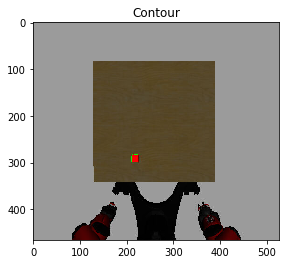

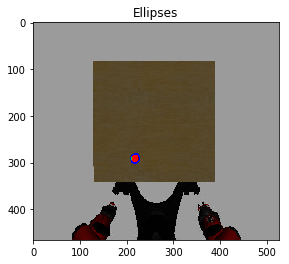

In [4]:
# Step 3. Find contours in the edge image, extract only those contours that are classified as external
# See https://docs.opencv.org/3.1.0/d4/d73/tutorial_py_contours_begin.html for more info
_, cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4. Discard contours that have an area bigger than 10 squared pixels and less than 200 squared pixels.
# If a contour within this range is found, append it and continue
outCnt = []
for c in cnts:
    perimeter = cv2.arcLength(c,True)
    print "Perimeter: " + str(perimeter)
    if perimeter >= 30 and perimeter <= 300:
        outCnt.append(c)
        #break  # Comment this if you want to detect more than one contour
        
# Step 5. For the selected contour, retrieve the contour centroid location,
# major axis length, minor axis length and major axis orientation
# See http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT2/node3.html for more info
# cv2.fitEllipse does the job in this case.
# (x,y) is the contour centroid location
# MA and ma are the major and minor axes
# angle is the major axis orientation (angle is wrt the y-axis in the image)
centroid = []
angle = []
out_img = rgb_img.copy()
out_ellipse = []
for c in outCnt:
    (x,y),(MA,ma),angle = cv2.fitEllipse(c)
    centroid.append((x,y))
    
    out_ellipse.append(cv2.fitEllipse(c))

    # Printing and displaying results
    cv2.drawContours(out_img, [c], -1, (0, 255, 0), 1)

    print "Centroid: " + str((x,y))
    print "Angle: " + str(angle) # With respect to y in the image

# Display contour on the rgb image
plt.imshow(out_img)
plt.title('Contour')
plt.show()

# Display ellipse on the out_img (this will show the contour and the fitted ellipse)
for each_ellipse in out_ellipse:
    cv2.ellipse(out_img, each_ellipse, (0,0,255), 2)

plt.imshow(out_img)
plt.title('Ellipses')
plt.show()


You now need to wrap the above code into a ROS node that subscribes to the image and point cloud topic. This node will allow you to extract useful information about the imaged scene and turn it into a pose such that Baxter can pick it up. To do this, you will create a ROS node that:

* subscribes to the image and point cloud topics,
* use a service to trigger image capturing and the above vision pipeline; and
* publish the block's pose and orientation such that another node can take those values and actuate Baxter to pick it up.

The above functionality can be found in the `detect_blocks.py` in the `~/Desktop/RFLabs/lab5/code` folder. So copy this file inside your `lab5_pkg` package (remember to place the code inside the `src` folder and make it executable).

Images are streamed continuously; so we would like to have control in terms of commanding Baxter to go and pick up the red block when we want. We can do the latter by creating a service file that indicates when Baxter can capture an image (More about ROS services [here](http://wiki.ros.org/ROS/Tutorials/WritingServiceClient%28python%29) or Lecture 2). So make a directory named `srv` inside `lab5_pkg` (e.g. `mkdir` in the terminal, or use the file manager to create the folder) and create a new file called `capture.srv`. Open this file and paste the following:

```
bool capture
---
bool success
```

From Lecture 2, we know that `capture` is the request and `success` the response. You now need to tell ROS that your package has a service that needs to be compiled. So edit `lab5_pkg` `CMakeLists.txt` file, locate `add_service_files` and `generate_messages` and replace with the following respectively:

```
## Generate services in the 'srv' folder
add_service_files(
   FILES
   capture.srv
)
```

```
## Generate added messages and services with any dependencies listed here
generate_messages(
   DEPENDENCIES
   std_msgs
)
```

and uncomment (or copy/paste) the following lines in `package.xml`:

``` xml
<build_depend>message_generation</build_depend>
<build_export_depend>message_generation</build_export_depend>
<exec_depend>message_runtime</exec_depend>
```

Finally, run `catkin_make`. You now have a vision ROS node that will detect blocks; the next step is to create a node that:

* takes the block's pose information; and,
* actuates Baxter.

For the above, you can use the code in Lab 4 using MoveIt or a ROS node ready to use in `~/Desktop/RFLabs/code/move_baxter.py`. For the latter, move it to your `lab5_pkg`, `catkin_make` then source your workspace.

## Test your nodes!

Before you test everything, Ctrl-C all running nodes in the terminals. While testing all nodes here, you would need to source every terminal to register your `rf_ws` workspace. So before you embark sourcing all terminals, you can echo to `.bashrc` the source of your `rf_ws` as follows: `echo "source ~/rf_ws/devel/setup.bash" >> ~/.bashrc`; this will save you time and forget about sourcing all terminals ;) After this, close all terminal windows, and every time you open a new terminal, `.bashrc` will be sourced automatically.

Now, run the following commands (each in a different terminal):

Terminal 1:
``` bash
roslaunch baxter_gazebo baxter_world.launch
```

Remember that you have to wait until Gazebo has completely loaded Baxter, then run the following:

Terminal 2:
``` bash
rosrun baxter_tools enable_robot.py -e
rosrun baxter_interface joint_trajectory_action_server.py
```
Terminal 3:
``` bash
roslaunch baxter_moveit_config baxter_grippers.launch
```

Terminal 4:
``` bash
rosrun lab5_pkg add_gazebo_models.py
```

Terminal 5 (wait for the **Node ready** message before moving to the next command):
``` bash
rosrun lab5_pkg detect_blocks.py
```

Terminal 6 (wait for the **Node ready** message before moving to the next command):
``` bash
rosrun lab5_pkg move_baxter.py
```

and, finally, call the service in a new terminal as follows:

``` bash
rosservice call /lab5_pkg/capture "capture: true"
```

`detect_blocks.py` will save images showing the input image and the detection at `~/workspace/rf_ws/`, you can use the file manager to open the images and inspect them :)

Keep calling the service after every pick-n'-place iteration. Will Baxter or the vision module fail at some point?

## Challenge
* Try moving the block using gazebo tools 
* Can you make the whole system to run continuously (tip: call the service inside move_baxter.py, check this [tutorial](http://wiki.ros.org/ROS/Tutorials/WritingServiceClient%28python%29#rospy_tutorials.2BAC8-Tutorials.2BAC8-WritingServiceClient.Writing_the_Client_Node) or Lecture 2)